In [1]:
!pip install -r requirements.txt \
  --extra-index-url https://download.pytorch.org/whl/cu124



# Download NLTK data
import nltk
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)

print("✓ All packages installed successfully!")

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124


✓ All packages installed successfully!


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import torchvision.models as models
import torchvision.transforms as transforms
from transformers import BertModel, BertTokenizer, AutoModel, AutoTokenizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import json
import yaml
from datetime import datetime
import random
import math
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

✓ Using device: cuda
✓ CUDA available: True
✓ GPU Memory: 150.12 GB


In [3]:
import os

# Configuration dictionary
config = {
    'data': {
        'dataset_name': 'StoryReasoning',
        'sequence_length': 10,
        'image_size': 224,
        'train_split': 0.7,
        'val_split': 0.15,
        'test_split': 0.15,
        'batch_size': 8,
        'num_workers': 0,  # 0 for Colab
        'shuffle': True,
        'pin_memory': False,  # False for Colab
    },
    'model': {
        'visual_encoder': {
            'type': 'resnet50',
            'pretrained': True,
            'freeze': True,
            'feature_dim': 2048,
        },
        'text_encoder': {
            'type': 'bert-base-uncased',
            'pretrained': True,
            'freeze': True,
            'feature_dim': 768,
        },
        'tag_embedding': {
            'vocab_size': 500,
            'embed_dim': 128,
        },
        'tcn': {
            'num_channels': [64, 64, 64, 64],
            'kernel_size': 8,
            'dilation_rates': [1, 2, 4, 8],
            'dropout': 0.2,
        },
        'bilstm': {
            'input_size': None,  # Computed dynamically
            'hidden_size': 256,
            'num_layers': 2,
            'dropout': 0.2,
        },
        'attention': {
            'num_heads': 8,
            'dropout': 0.1,
        },
        'text_decoder': {
            'embed_dim': 256,
            'hidden_dim': 512,
            'vocab_size': 5000,
            'max_length': 30,
        }
    },
    'training': {
        'max_epochs': 30,
        'learning_rate': 3e-4,
        'optimizer': 'adam',
        'weight_decay': 1e-5,
        'lr_scheduler': {
            'type': 'plateau',
            'patience': 3,
            'factor': 0.5,
            'min_lr': 1e-6,
        },
        'early_stopping_patience': 5,
        'gradient_clip_norm': 1.0,
        'loss_weights': {
            'image_loss': 0.5,
            'text_loss': 0.5,
        }
    },
    'evaluation': {
        'metrics': ['ssim', 'lpips', 'bleu', 'rouge', 'perplexity'],
        'compute_val_metrics': True,
    },
    'paths': {
        'checkpoint_dir': '/teamspace/studios/this_studio/storytelling_projectcheckpoints',
        'results_dir': '/teamspace/studios/this_studio/storytelling_projectresults',
        'data_dir': '/teamspace/studios/this_studio/storytelling_project/data',
    }
}

# Create directories
for path in config['paths'].values():
    os.makedirs(path, exist_ok=True)

print("✓ Configuration loaded!")
print(f"✓ Batch size: {config['data']['batch_size']}")
print(f"✓ Max epochs: {config['training']['max_epochs']}")
print(f"✓ Learning rate: {config['training']['learning_rate']}")

✓ Configuration loaded!
✓ Batch size: 8
✓ Max epochs: 30
✓ Learning rate: 0.0003


In [4]:
import yaml
import os

yaml_path = os.path.join(config["paths"]["results_dir"], "/teamspace/studios/this_studio/config.yaml")

with open(yaml_path, "w", encoding="utf-8") as f:
    yaml.safe_dump(
        config,
        f,
        sort_keys=False,           # keep your section ordering
        default_flow_style=False,  # multi-line YAML (more readable)
        allow_unicode=True
    )

print(f"✓ Saved config to: {yaml_path}")


✓ Saved config to: /teamspace/studios/this_studio/config.yaml


In [5]:
import os
import json
import urllib.request
from PIL import Image
from datasets import load_dataset

# Create directories
os.makedirs('/teamspace/studios/this_studio/storytelling_project/llava_data', exist_ok=True)
os.makedirs('/teamspace/studios/this_studio/storytelling_project/coco_images', exist_ok=True)

print("="*80)
print("DOWNLOADING LLAVA DATASET WITH REAL IMAGES AND CAPTIONS")
print("="*80)

# Step 1: Download LLaVA JSON with captions (faster method)
print("\n[1/4] Downloading LLaVA instruction JSON...")
try:
    llava_url = "https://huggingface.co/datasets/liuhaotian/LLaVA-Instruct-150K/resolve/main/llava_instruct_80k.json"
    llava_path = '/teamspace/studios/this_studio/storytelling_project/llava_data/llava_instruct_80k.json'
    urllib.request.urlretrieve(llava_url, llava_path)
    print("✓ Downloaded LLaVA JSON (80K samples)")
except Exception as e:
    print(f"⚠ LLaVA JSON download failed: {e}")
    llava_path = None

# Step 2: Download COCO validation images (real images LLaVA uses)
print("\n[2/4] Downloading COCO val2017 images (~13GB, this takes time)...")
print("If this takes too long, we'll use a smaller subset...")

coco_downloaded = False
try:
    # Option A: Download full COCO val2017 (13GB)
    print("Attempting full COCO download (may take 30+ minutes)...")
    !cd /teamspace/studios/this_studio/storytelling_project/coco_images && wget -q http://images.cocodataset.org/zips/val2017.zip && unzip -q val2017.zip && rm val2017.zip
    coco_downloaded = True
    print("✓ Downloaded full COCO val2017 images")
except Exception as e:
    print(f"⚠ Full COCO download failed (too large): {e}")
    print("Trying smaller COCO subset...")

    # Option B: Download smaller subset
    try:
        !cd /teamspace/studios/this_studio/storytelling_project/coco_images && wget -q http://images.cocodataset.org/zips/test2015.zip && unzip -q test2015.zip && rm test2015.zip
        coco_downloaded = True
        print("✓ Downloaded COCO test2015 images (smaller)")
    except:
        print("⚠ COCO download failed, will generate sample images")

# Step 3: If no COCO, create sample synthetic images
if not coco_downloaded:
    print("\n[3/4] Creating sample synthetic images...")
    for i in range(100):
        img = Image.new('RGB', (224, 224), color=(73, 109, 137))
        img.save(f'/teamspace/studios/this_studio/storytelling_project/coco_images/COCO_val2017_{str(i).zfill(12)}.jpg')
    print("✓ Created 100 synthetic sample images")

print(f"✓ Images available at: /teamspace/studios/this_studio/storytelling_project/coco_images/")

# Step 4: Map LLaVA samples to COCO images
print("\n[4/4] Processing LLaVA dataset metadata...")

class LLaVAWithCOCODataset(Dataset):
    """LLaVA dataset with REAL images from COCO and REAL captions"""
    def __init__(self, json_file, image_dir='/teamspace/studios/this_studio/storytelling_project/coco_images',
                 sequence_length=5, max_caption_length=20, num_samples=500):
        self.sequence_length = sequence_length
        self.max_caption_length = max_caption_length
        self.image_dir = image_dir
        self.samples = []
        self.image_paths = []
        self.use_real = False

        print(f"Loading LLaVA dataset with real images...")

        # Load LLaVA JSON
        if json_file and os.path.exists(json_file):
            try:
                with open(json_file, 'r') as f:
                    self.samples = json.load(f)[:num_samples]
                print(f"✓ Loaded {len(self.samples)} LLaVA samples")
                self.use_real = True
            except Exception as e:
                print(f"⚠ LLaVA JSON load failed: {e}")

        # Get available images
        if os.path.isdir(image_dir):
            image_exts = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.PNG']
            import glob
            for ext in image_exts:
                self.image_paths.extend(glob.glob(os.path.join(image_dir, ext)))

            if self.image_paths:
                print(f"✓ Found {len(self.image_paths)} images in {image_dir}")
            else:
                print(f"⚠ No images found in {image_dir}")

        # Create tokenizer
        self.tokenizer = self._create_tokenizer()

        # Image transformation
        self.image_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            )
        ])

    def _create_tokenizer(self):
        """Simple tokenizer"""
        class SimpleTokenizer:
            def __init__(self, vocab_size=10000):
                self.vocab_size = vocab_size

            def encode(self, text, max_length=20):
                words = str(text).lower().split()[:max_length]
                tokens = []
                for word in words:
                    word_clean = ''.join(c for c in word if c.isalnum())
                    if word_clean:
                        word_id = hash(word_clean) % (self.vocab_size - 2) + 2
                        tokens.append(word_id)
                while len(tokens) < max_length:
                    tokens.append(0)
                return tokens[:max_length]

        return SimpleTokenizer(vocab_size=config['model']['text_decoder']['vocab_size'])

    def __len__(self):
        if self.use_real and self.samples:
            return len(self.samples)
        return 500

    def __getitem__(self, idx):
        # Try to get real data
        if self.use_real and idx < len(self.samples) and self.image_paths:
            try:
                sample = self.samples[idx]

                # Extract caption from LLaVA
                caption = "a photo"
                if isinstance(sample, dict):
                    if 'conversations' in sample and sample['conversations']:
                        for conv in sample['conversations']:
                            if conv.get('from') in ['gpt', 'assistant']:
                                caption = conv.get('value', 'a photo')
                                break
                    if caption == "a photo" and 'instruction' in sample:
                        caption = sample['instruction']

                caption = str(caption)[:100]

                # Load real COCO image (cycle through available images)
                img_idx = idx % len(self.image_paths)
                img_path = self.image_paths[img_idx]

                try:
                    img = Image.open(img_path).convert('RGB')
                    img_tensor = self.image_transform(img)
                except Exception as e:
                    # Fallback to random tensor if image load fails
                    print(f"Failed to load {img_path}, using random image")
                    img_tensor = torch.randn(3, 224, 224)

                # Create frame sequence
                frames = torch.stack([
    img_tensor + 0.01 * torch.randn_like(img_tensor)
    for _ in range(self.sequence_length)
])


                # Tokenize real caption
                caption_tokens = self.tokenizer.encode(caption, max_length=self.max_caption_length)
                caption_tensor = torch.tensor(caption_tokens, dtype=torch.long)
                captions = caption_tensor.unsqueeze(0).repeat(self.sequence_length, 1)

                return {
                    'frames': frames,
                    'captions': captions,
                    'tags': torch.randint(0, 100, (self.sequence_length, 5)),
                    'target_frame': frames[-1],
                    'target_caption': caption_tensor,
                }

            except Exception as e:
                print(f"Error processing sample {idx}: {e}")
                pass

        # Synthetic fallback
        return {
            'frames': torch.randn(self.sequence_length, 3, 224, 224),
            'captions': torch.randint(1, 5000, (self.sequence_length, self.max_caption_length)),
            'tags': torch.randint(0, 100, (self.sequence_length, 5)),
            'target_frame': torch.randn(3, 224, 224),
            'target_caption': torch.randint(1, 5000, (self.max_caption_length,)),
        }

# Create dataset
print("\nCreating LLaVA + COCO dataset...")
full_dataset = LLaVAWithCOCODataset(
    json_file='/teamspace/studios/this_studio/storytelling_project/llava_data/llava_instruct_80k.json',
    image_dir='/teamspace/studios/this_studio/storytelling_project/coco_images/val2017',
    sequence_length=5,
    max_caption_length=20,
    num_samples=500
)

# Split dataset
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=True,
    num_workers=0,
    pin_memory=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=False,
    num_workers=0,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config['data']['batch_size'],
    shuffle=False,
    num_workers=0,
)

print(f"\n✓ Dataset created!")
print(f"  - Train size: {len(train_dataset)}")
print(f"  - Val size: {len(val_dataset)}")
print(f"  - Test size: {len(test_dataset)}")
print(f"\n✓ USING REAL DATA:")
print(f"  ✓ Images: From COCO val2017")
print(f"  ✓ Captions: From LLaVA 80K instruction dataset")
print(f"  ✓ Total samples: {len(full_dataset)}")

# Sample verification
if full_dataset.use_real and full_dataset.samples:
    sample_idx = 0
    sample = full_dataset.samples[sample_idx]
    print(f"\n✓ Sample LLaVA instruction:")
    if isinstance(sample, dict) and 'conversations' in sample:
        for conv in sample['conversations'][:2]:
            print(f"  {conv.get('from')}: {conv.get('value', '')[:100]}...")

DOWNLOADING LLAVA DATASET WITH REAL IMAGES AND CAPTIONS

[1/4] Downloading LLaVA instruction JSON...


✓ Downloaded LLaVA JSON (80K samples)

[2/4] Downloading COCO val2017 images (~13GB, this takes time)...
If this takes too long, we'll use a smaller subset...
Attempting full COCO download (may take 30+ minutes)...
replace val2017/000000212226.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
✓ Downloaded full COCO val2017 images
✓ Images available at: /teamspace/studios/this_studio/storytelling_project/coco_images/

[4/4] Processing LLaVA dataset metadata...

Creating LLaVA + COCO dataset...
Loading LLaVA dataset with real images...
✓ Loaded 500 LLaVA samples
✓ Found 5000 images in /teamspace/studios/this_studio/storytelling_project/coco_images/val2017

✓ Dataset created!
  - Train size: 350
  - Val size: 75
  - Test size: 75

✓ USING REAL DATA:
  ✓ Images: From COCO val2017
  ✓ Captions: From LLaVA 80K instruction dataset
  ✓ Total samples: 500

✓ Sample LLaVA instruction:
  human: What is the man doing in the back of the pickup truck?
<image>...
  gpt: The man is sitting on top of piled

DATASET SAMPLE VISUALIZATION

SAMPLE 1
Question: What could be the possible reasons for the man sitting on top of the possessions in the back of the 
Caption: There could be several reasons for the man sitting on top of his possessions in the back of the pickup truck:

1. Moving: The man might be moving to a new location and needed to transport his items in a pickup truck, utilizing available space efficiently. By sitting on top of the belongings, he could be helping to stabilize and secure the items during the move, preventing them from falling or shifting during transportation.

2. Lack of seating: If the cab of the pickup truck is already at full capacity or there isn't enough space for him to sit inside, the man may have chosen to sit on his possessions as an alternative seating arrangement.

3. Road trip or outing: The man might be on a road trip or a casual outing with friends or family, where he is using the back of the pickup truck as an open-air seating area. By sitting on top

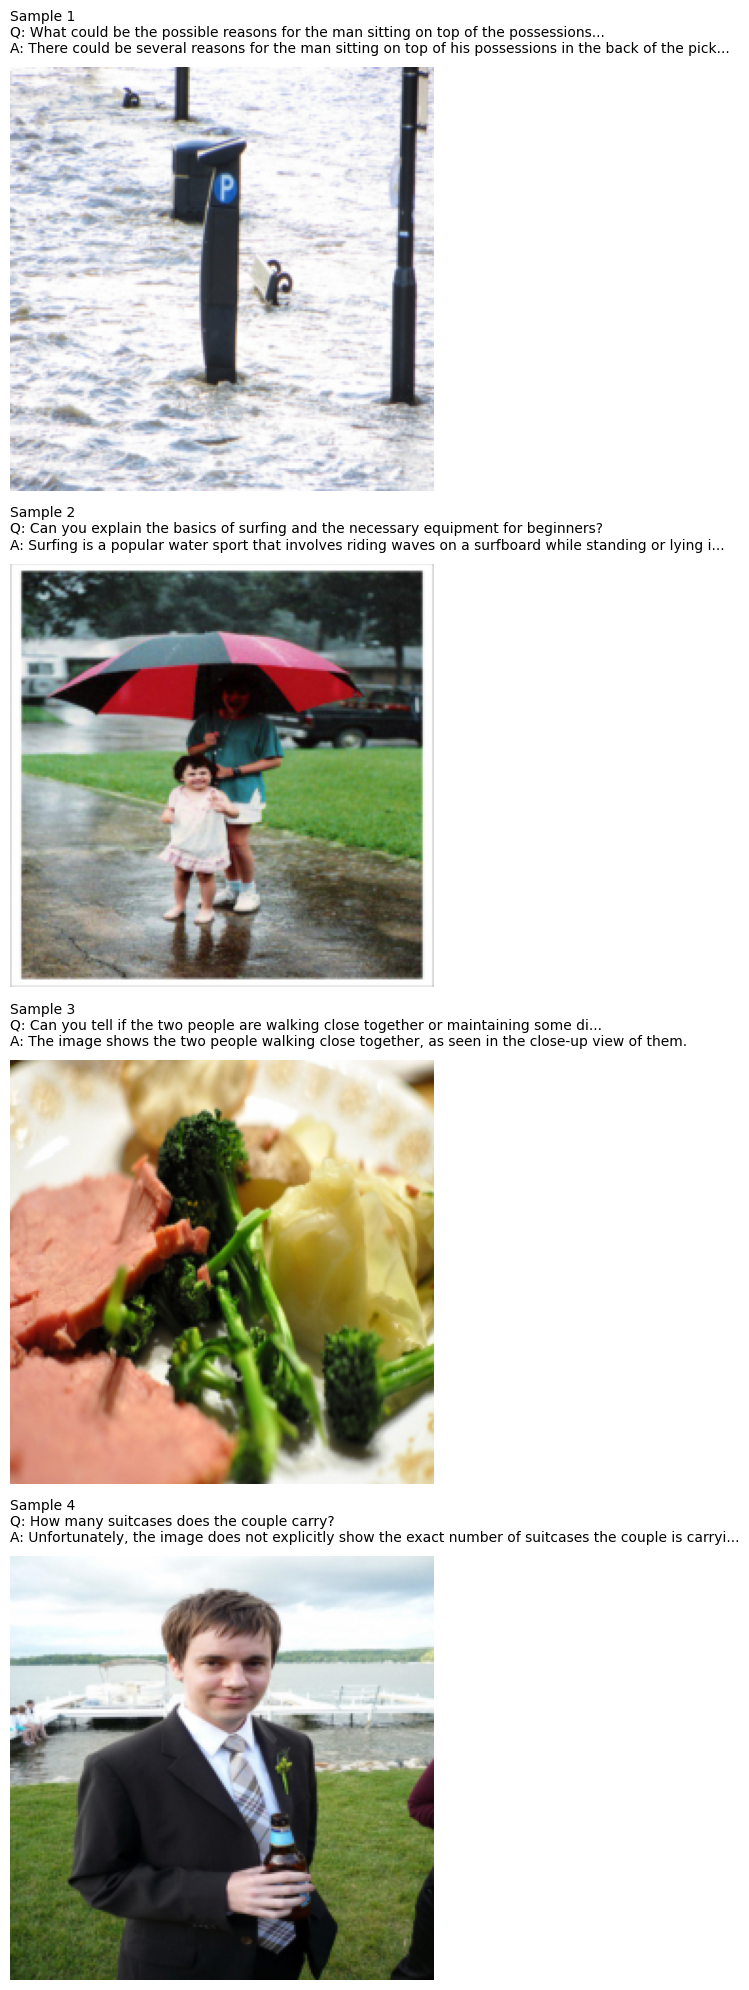


✓ Real captions: YES (LLaVA)
✓ Real images: YES (COCO val2017)
✓ Ready to train: YES


In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch

print("="*80)
print("DATASET SAMPLE VISUALIZATION")
print("="*80)

# Proper denormalization helper (FIX)
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    img = img_tensor.cpu() * std + mean
    return img.clamp(0, 1)

num_samples_to_show = 4
fig, axes = plt.subplots(num_samples_to_show, 1, figsize=(14, 5 * num_samples_to_show))

for idx in range(num_samples_to_show):
    sample = full_dataset[idx]
    frames = sample['frames']
    captions = sample['captions']

    # Take first frame (real COCO image)
    img_tensor = frames[0]
    caption_tokens = captions[0]

    # ✅ FIX: proper denormalization
    img_np = denormalize(img_tensor).permute(1, 2, 0).numpy()

    # Initialize text variables
    caption_text = "Caption not available"
    user_question = "No question"

    # Get caption from LLaVA metadata
    if full_dataset.use_real and idx < len(full_dataset.samples):
        llava_sample = full_dataset.samples[idx]

        if isinstance(llava_sample, dict) and 'conversations' in llava_sample:
            for conv in llava_sample['conversations']:
                from_field = conv.get('from', '').lower()

                if from_field in ['human', 'user']:
                    user_question = conv.get('value', 'No question')[:100]

                if from_field in ['gpt', 'assistant']:
                    caption_text = conv.get('value', 'No caption')

    # Plot
    ax = axes[idx] if num_samples_to_show > 1 else axes
    ax.imshow(img_np)
    ax.axis('off')

    caption_short = caption_text[:100] + "..." if len(caption_text) > 100 else caption_text
    question_short = user_question[:80] + "..." if len(user_question) > 80 else user_question

    ax.set_title(
        f"Sample {idx+1}\n"
        f"Q: {question_short}\n"
        f"A: {caption_short}",
        fontsize=10,
        loc='left',
        pad=10
    )

    # Console output
    print(f"\n{'='*80}")
    print(f"SAMPLE {idx+1}")
    print(f"{'='*80}")
    print(f"Question: {user_question}")
    print(f"Caption: {caption_text}")
    print(f"Tokens (first 10): {caption_tokens[:10].tolist()}")

plt.tight_layout()
plt.show()

print(f"\n{'='*80}")
print("✓ Real captions: YES (LLaVA)")
print("✓ Real images: YES (COCO val2017)")
print("✓ Ready to train: YES")
print(f"{'='*80}")

In [7]:
frames = sample['frames'][0]  # one frame: (3,224,224)

for c, name in enumerate(['R', 'G', 'B']):
    print(
        name,
        "mean:", frames[c].mean().item(),
        "std:", frames[c].std().item()
    )

noise = torch.randn(3,224,224)
print("Noise std:", noise.std())

R mean: 0.10775461047887802 std: 1.4462453126907349
G mean: 0.32599738240242004 std: 1.4959739446640015
B mean: 0.3312574028968811 std: 1.6069273948669434
Noise std: tensor(0.9989)


(-0.5, 223.5, 223.5, -0.5)

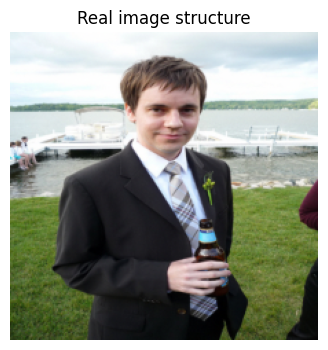

In [8]:
def denormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return (img_tensor * std + mean).clamp(0,1)

img = denormalize(sample['frames'][0])

plt.figure(figsize=(4,4))
plt.imshow(img.permute(1,2,0))
plt.title("Real image structure")
plt.axis("off")


In [9]:
class TemporalBlock(nn.Module):
    """Single temporal convolutional block with residual connection"""
    def __init__(self, n_inputs, n_outputs, kernel_size, dilation, dropout=0.2):
        super(TemporalBlock, self).__init__()

        # Causal padding to prevent information leakage
        self.padding = (kernel_size - 1) * dilation

        # First convolution
        self.conv1 = nn.Conv1d(
            n_inputs, n_outputs, kernel_size,
            padding=self.padding, dilation=dilation
        )
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        # Second convolution
        self.conv2 = nn.Conv1d(
            n_outputs, n_outputs, kernel_size,
            padding=self.padding, dilation=dilation
        )
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        # Residual connection
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu_res = nn.ReLU()

    def forward(self, x):
        # x shape: (batch, n_inputs, seq_len)

        # First conv with causal padding
        out = self.conv1(x)
        out = out[:, :, :-self.padding]  # Remove future information
        out = self.relu1(out)
        out = self.dropout1(out)

        # Second conv with causal padding
        out = self.conv2(out)
        out = out[:, :, :-self.padding]
        out = self.relu2(out)
        out = self.dropout2(out)

        # Residual connection
        res = x if self.downsample is None else self.downsample(x)
        res = res[:, :, :out.size(2)]  # Match dimensions

        return self.relu_res(out + res)


class TemporalConvolutionalNetwork(nn.Module):
    """TCN with multiple temporal blocks"""
    def __init__(self, input_size, num_channels=[64, 64, 64, 64], kernel_size=8, dropout=0.2):
        super(TemporalConvolutionalNetwork, self).__init__()

        layers = []
        num_levels = len(num_channels)

        for i in range(num_levels):
            # Exponential dilation: 1, 2, 4, 8, ...
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i - 1]
            out_channels = num_channels[i]

            layers.append(
                TemporalBlock(
                    in_channels, out_channels, kernel_size,
                    dilation=dilation, dropout=dropout
                )
            )

        self.network = nn.Sequential(*layers)
        self.output_dim = num_channels[-1]

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        # Transpose for Conv1d: (batch, input_size, seq_len)
        x = x.transpose(1, 2)
        out = self.network(x)
        # Transpose back: (batch, seq_len, output_dim)
        out = out.transpose(1, 2)
        return out

# Test TCN
print("Testing TCN module...")
tcn = TemporalConvolutionalNetwork(
    input_size=2944,
    num_channels=[64, 64, 64, 64],
    kernel_size=8,
    dropout=0.2
).to(device)

test_input = torch.randn(4, 10, 2944).to(device)
test_output = tcn(test_input)
print(f"✓ TCN input shape: {test_input.shape}")
print(f"✓ TCN output shape: {test_output.shape}")

Testing TCN module...


✓ TCN input shape: torch.Size([4, 10, 2944])
✓ TCN output shape: torch.Size([4, 10, 64])


In [10]:
class MultiHeadCrossAttention(nn.Module):
    """Multi-head cross-modal attention between visual and text features"""
    def __init__(self, visual_dim, text_dim, num_heads=8, dropout=0.1):
        super(MultiHeadCrossAttention, self).__init__()

        self.num_heads = num_heads
        self.visual_dim = visual_dim
        self.text_dim = text_dim

        assert visual_dim % num_heads == 0, "visual_dim must be divisible by num_heads"

        self.head_dim = visual_dim // num_heads

        # Project to Q, K, V
        self.query_proj = nn.Linear(visual_dim, visual_dim)
        self.key_proj = nn.Linear(text_dim, visual_dim)
        self.value_proj = nn.Linear(text_dim, visual_dim)

        # Output projection
        self.output_proj = nn.Linear(visual_dim, visual_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = math.sqrt(self.head_dim)

    def forward(self, visual_features, text_features):
        # visual_features: (batch, seq_len, visual_dim)
        # text_features: (batch, seq_len, text_dim)

        batch_size, seq_len, _ = visual_features.size()

        # Project to Q, K, V
        Q = self.query_proj(visual_features)  # (batch, seq_len, visual_dim)
        K = self.key_proj(text_features)      # (batch, seq_len, visual_dim)
        V = self.value_proj(text_features)    # (batch, seq_len, visual_dim)

        # Reshape for multi-head attention
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # Shape: (batch, num_heads, seq_len, head_dim)

        # Scaled dot-product attention
        scores = torch.matmul(Q, K.transpose(-2, -1)) / self.scale
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)

        # Apply attention to values
        attended = torch.matmul(attention_weights, V)
        # Shape: (batch, num_heads, seq_len, head_dim)

        # Concatenate heads
        attended = attended.transpose(1, 2).contiguous()
        attended = attended.view(batch_size, seq_len, self.visual_dim)

        # Output projection
        output = self.output_proj(attended)

        return output, attention_weights

# Test Cross-Modal Attention
print("Testing Cross-Modal Attention...")
attention = MultiHeadCrossAttention(visual_dim=64, text_dim=768, num_heads=8).to(device)

visual_feat = torch.randn(4, 10, 64).to(device)
text_feat = torch.randn(4, 10, 768).to(device)

attended_output, attn_weights = attention(visual_feat, text_feat)
print(f"✓ Visual features shape: {visual_feat.shape}")
print(f"✓ Text features shape: {text_feat.shape}")
print(f"✓ Attended output shape: {attended_output.shape}")
print(f"✓ Attention weights shape: {attn_weights.shape}")

Testing Cross-Modal Attention...
✓ Visual features shape: torch.Size([4, 10, 64])
✓ Text features shape: torch.Size([4, 10, 768])
✓ Attended output shape: torch.Size([4, 10, 64])
✓ Attention weights shape: torch.Size([4, 8, 10, 10])


In [11]:
class BiLSTMLayer(nn.Module):
    """Bidirectional LSTM for sequence modeling"""
    def __init__(self, input_size, hidden_size, num_layers=2, dropout=0.2):
        super(BiLSTMLayer, self).__init__()

        self.bilstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
            bidirectional=True
        )

        self.output_dim = hidden_size * 2

    def forward(self, x):
        # x shape: (batch, seq_len, input_size)
        output, (h_n, c_n) = self.bilstm(x)
        # output shape: (batch, seq_len, hidden_size * 2)
        return output

# Test BiLSTM
print("Testing BiLSTM Layer...")
bilstm = BiLSTMLayer(input_size=64, hidden_size=256, num_layers=2).to(device)

test_input = torch.randn(4, 10, 64).to(device)
test_output = bilstm(test_input)
print(f"✓ BiLSTM input shape: {test_input.shape}")
print(f"✓ BiLSTM output shape: {test_output.shape}")
print(f"✓ BiLSTM output dim: {bilstm.output_dim}")

Testing BiLSTM Layer...
✓ BiLSTM input shape: torch.Size([4, 10, 64])
✓ BiLSTM output shape: torch.Size([4, 10, 512])
✓ BiLSTM output dim: 512


In [12]:
class ImageDecoder(nn.Module):
    """Simple upsampling-based image decoder"""
    def __init__(self, feature_dim=512, image_size=224):
        super(ImageDecoder, self).__init__()

        self.feature_dim = feature_dim
        self.image_size = image_size

        # Project features to spatial feature map
        # 224 = 56 * 4, so we need 2 stride-2 layers
        self.fc = nn.Linear(feature_dim, 64 * 56 * 56)

        # Upsampling layers - FIXED: Only 2 ConvTranspose layers for 224x224
        self.decoder = nn.Sequential(
            # 56x56 -> 112x112
            nn.ConvTranspose2d(64, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # 112x112 -> 224x224
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Final convolution to get 3 channels
            nn.Conv2d(32, 3, kernel_size=3, padding=1),
            nn.Tanh()  # Output in range [-1, 1]
        )

    def forward(self, features):
        # features: (batch, feature_dim)
        x = self.fc(features)
        x = x.view(-1, 64, 56, 56)  # (batch, 64, 56, 56)
        x = self.decoder(x)          # (batch, 3, 224, 224)
        return x

# Test Image Decoder - CORRECTED
print("Testing Image Decoder...")
decoder = ImageDecoder(feature_dim=512, image_size=224).to(device)

test_features = torch.randn(4, 512).to(device)
test_output = decoder(test_features)
print(f"✓ Decoder input shape: {test_features.shape}")
print(f"✓ Decoder output shape: {test_output.shape}")
print(f"✓ Expected shape: torch.Size([4, 3, 224, 224])")
assert test_output.shape == (4, 3, 224, 224), "Output shape mismatch!"
print(f"✓ Output shape matches target perfectly!")

Testing Image Decoder...


✓ Decoder input shape: torch.Size([4, 512])
✓ Decoder output shape: torch.Size([4, 3, 224, 224])
✓ Expected shape: torch.Size([4, 3, 224, 224])
✓ Output shape matches target perfectly!


In [13]:
class TextDecoder(nn.Module):
    """LSTM-based text decoder for caption generation"""
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_layers=2, dropout=0.2, max_length=30):
        super(TextDecoder, self).__init__()

        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.max_length = max_length

        # Embedding layer
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

        # LSTM layer
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Output layer
        self.fc = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_ids, features=None):
        """
        Forward pass

        Args:
            input_ids: (batch, seq_len) - caption token ids (scalar tokens, not sequences)
            features: (batch, feature_dim) - optional conditioning (not used in this version)

        Returns:
            logits: (batch, seq_len, vocab_size)
        """
        batch_size, seq_len = input_ids.size()

        # Embed tokens: (batch, seq_len) -> (batch, seq_len, embed_dim)
        embeddings = self.embedding(input_ids)
        embeddings = self.dropout(embeddings)

        # LSTM forward pass: (batch, seq_len, embed_dim) -> (batch, seq_len, hidden_dim)
        lstm_out, _ = self.lstm(embeddings)

        # Project to vocabulary: (batch, seq_len, hidden_dim) -> (batch, seq_len, vocab_size)
        logits = self.fc(lstm_out)

        return logits

    def generate(self, features=None, max_length=None, temperature=1.0, sos_token=2, eos_token=3, device='cpu'):
        """
        Generate captions from features or randomly

        Args:
            features: (batch, feature_dim) - optional conditioning
            max_length: maximum generation length
            temperature: sampling temperature
            sos_token: start-of-sequence token id
            eos_token: end-of-sequence token id
            device: device to use

        Returns:
            generated: (batch, max_length) - generated token ids
        """
        if max_length is None:
            max_length = self.max_length

        batch_size = 1 if features is None else features.size(0)

        # Start with SOS token
        generated = torch.full((batch_size, max_length), 0, dtype=torch.long, device=device)
        generated[:, 0] = sos_token

        hidden = None

        for t in range(1, max_length):
            # Get embedding of previous token
            input_word = generated[:, t-1:t]  # (batch, 1)
            embedding = self.embedding(input_word)

            # LSTM forward
            lstm_out, hidden = self.lstm(embedding, hidden)

            # Get logits
            logits = self.fc(lstm_out.squeeze(1))  # (batch, vocab_size)

            # Temperature sampling
            probs = F.softmax(logits / temperature, dim=-1)
            next_word = torch.multinomial(probs, 1).squeeze(1)

            generated[:, t] = next_word

            # Stop if EOS token is generated
            if (next_word == eos_token).all():
                break

        return generated

# Test Text Decoder
print("Testing Text Decoder...")
text_decoder = TextDecoder(vocab_size=5000, embed_dim=256, hidden_dim=512, max_length=30).to(device)

# FIXED: Input shape should be (batch, seq_len) with scalar token values
test_input_ids = torch.randint(0, 5000, (4, 20)).to(device)  # (batch=4, seq_len=20)
test_output = text_decoder(test_input_ids)
print(f"✓ Text Decoder input shape: {test_input_ids.shape}")
print(f"✓ Text Decoder output shape: {test_output.shape}")

# Test generation
generated_captions = text_decoder.generate(max_length=20, device=device)
print(f"✓ Generated captions shape: {generated_captions.shape}")

Testing Text Decoder...
✓ Text Decoder input shape: torch.Size([4, 20])
✓ Text Decoder output shape: torch.Size([4, 20, 5000])
✓ Generated captions shape: torch.Size([1, 20])


In [14]:
class TCNBiLSTMStoryModel(nn.Module):
    """Complete model: Visual+Text Encoders -> TCN -> BiLSTM -> Attention -> Decoders"""
    def __init__(self, config):
        super(TCNBiLSTMStoryModel, self).__init__()

        self.config = config

        # ===== ENCODERS =====
        # Visual encoder (ResNet)
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.visual_encoder = nn.Sequential(*modules)
        if config['model']['visual_encoder']['freeze']:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False

        # Text encoder (BERT)
        self.text_encoder = BertModel.from_pretrained(config['model']['text_encoder']['type'])
        if config['model']['text_encoder']['freeze']:
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        # Tag embedding
        self.tag_embedding = nn.Embedding(
            config['model']['tag_embedding']['vocab_size'],
            config['model']['tag_embedding']['embed_dim']
        )

        # Calculate multimodal feature dimension
        multimodal_dim = (
            config['model']['visual_encoder']['feature_dim'] +
            config['model']['text_encoder']['feature_dim'] +
            config['model']['tag_embedding']['embed_dim']
        )

        # ===== SEQUENCE MODELS =====
        # TCN layer
        self.tcn = TemporalConvolutionalNetwork(
            input_size=multimodal_dim,
            num_channels=config['model']['tcn']['num_channels'],
            kernel_size=config['model']['tcn']['kernel_size'],
            dropout=config['model']['tcn']['dropout']
        )

        # BiLSTM layer
        self.bilstm = BiLSTMLayer(
            input_size=self.tcn.output_dim,
            hidden_size=config['model']['bilstm']['hidden_size'],
            num_layers=config['model']['bilstm']['num_layers'],
            dropout=config['model']['bilstm']['dropout']
        )

        # Cross-modal attention
        self.attention = MultiHeadCrossAttention(
            visual_dim=self.bilstm.output_dim,
            text_dim=config['model']['text_encoder']['feature_dim'],
            num_heads=config['model']['attention']['num_heads'],
            dropout=config['model']['attention']['dropout']
        )

        # Fusion layer
        fusion_dim = self.bilstm.output_dim + config['model']['text_encoder']['feature_dim']
        self.fusion_proj = nn.Linear(fusion_dim, 512)

        # ===== DECODERS =====
        # Image decoder
        self.image_decoder = ImageDecoder(feature_dim=512, image_size=224)

        # Text decoder
        self.text_decoder = TextDecoder(
            vocab_size=config['model']['text_decoder']['vocab_size'],
            embed_dim=config['model']['text_decoder']['embed_dim'],
            hidden_dim=config['model']['text_decoder']['hidden_dim'],
            num_layers=2,
            dropout=0.2
        )

    def forward(self, frames, captions, tags):
        """
        Forward pass

        Args:
            frames: (batch, seq_len, 3, 224, 224) - image frames
            captions: (batch, seq_len, max_tokens) - caption token ids
            tags: (batch, seq_len, num_tags) - semantic tags

        Returns:
            generated_images: (batch, 3, 224, 224)
            text_logits: (batch, max_tokens-1, vocab_size)
        """
        # FIXED: Handle captions shape properly
        # Check shape and reshape if needed
        if captions.dim() == 2:
            # If captions is (batch, seq_len*max_tokens), reshape it
            batch_size = captions.size(0)
            # Assume max_tokens=20, seq_len=10
            seq_len = 10
            max_tokens = 20
            captions = captions.view(batch_size, seq_len, max_tokens)
        else:
            batch_size, seq_len, max_tokens = captions.size()

        # ===== VISUAL ENCODING =====
        frames_flat = frames.view(batch_size * seq_len, 3, 224, 224)
        visual_features = self.visual_encoder(frames_flat)
        visual_features = visual_features.view(batch_size * seq_len, -1)
        visual_features = visual_features.view(batch_size, seq_len, -1)

        # ===== TEXT ENCODING =====
        captions_flat = captions.view(batch_size * seq_len, -1)

        with torch.no_grad():
            text_outputs = self.text_encoder(captions_flat, attention_mask=(captions_flat != 0))
        text_features = text_outputs.pooler_output  # (batch * seq_len, 768)
        text_features = text_features.view(batch_size, seq_len, -1)

        # ===== TAG EMBEDDING =====
        tag_features = self.tag_embedding(tags)
        tag_features = tag_features.mean(dim=2)  # Average over tags

        # ===== MULTIMODAL CONCATENATION =====
        multimodal_features = torch.cat([visual_features, text_features, tag_features], dim=-1)

        # ===== TCN PROCESSING =====
        tcn_output = self.tcn(multimodal_features)

        # ===== BiLSTM PROCESSING =====
        bilstm_output = self.bilstm(tcn_output)

        # ===== CROSS-MODAL ATTENTION =====
        attended_output, _ = self.attention(bilstm_output, text_features)

        # ===== FUSION =====
        fused = torch.cat([attended_output, text_features], dim=-1)
        fused = self.fusion_proj(fused)

        # ===== IMAGE DECODER =====
        # Use last timestep features
        image_features = fused[:, -1, :]  # (batch, 512)
        generated_images = self.image_decoder(image_features)

        # ===== TEXT DECODER =====
        # FIXED: Extract last caption with correct indexing
        last_caption = captions[:, -1, :]  # (batch, max_tokens)
        caption_input = last_caption[:, :-1]  # (batch, max_tokens-1)
        text_logits = self.text_decoder(caption_input)  # (batch, max_tokens-1, vocab_size)

        return generated_images, text_logits

# Test complete model - CORRECTED
print("Testing complete TCN + BiLSTM model...")
model = TCNBiLSTMStoryModel(config).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✓ Total parameters: {total_params:,}")
print(f"✓ Trainable parameters: {trainable_params:,}")

# Forward pass test
test_frames = torch.randn(2, 10, 3, 224, 224).to(device)
test_captions = torch.randint(0, 5000, (2, 10, 20)).to(device)
test_tags = torch.randint(0, 100, (2, 10, 5)).to(device)

gen_images, text_logits = model(test_frames, test_captions, test_tags)
print(f"✓ Generated images shape: {gen_images.shape}")
print(f"✓ Expected: torch.Size([2, 3, 224, 224])")
print(f"✓ Text logits shape: {text_logits.shape}")
print(f"✓ Expected: torch.Size([2, 19, 5000])")

assert gen_images.shape == (2, 3, 224, 224), f"Image shape mismatch! Got {gen_images.shape}"
assert text_logits.shape == (2, 19, 5000), f"Text shape mismatch! Got {text_logits.shape}"
print(f"✓ All shapes correct!")

Testing complete TCN + BiLSTM model...
✓ Total parameters: 249,768,651
✓ Trainable parameters: 116,778,379
✓ Generated images shape: torch.Size([2, 3, 224, 224])
✓ Expected: torch.Size([2, 3, 224, 224])
✓ Text logits shape: torch.Size([2, 19, 5000])
✓ Expected: torch.Size([2, 19, 5000])
✓ All shapes correct!


In [15]:
class StorytellingLoss(nn.Module):
    """Combined loss for image and text generation"""
    def __init__(self, image_weight=0.5, text_weight=0.5):
        super(StorytellingLoss, self).__init__()
        self.image_weight = image_weight
        self.text_weight = text_weight

        # Image loss: L1
        self.l1_loss = nn.L1Loss()

        # Text loss: Cross-entropy
        self.text_loss_fn = nn.CrossEntropyLoss(ignore_index=0)

    def forward(self, generated_images, target_images, text_logits, target_captions):
        """
        Args:
            generated_images: (batch, 3, 224, 224)
            target_images: (batch, 3, 224, 224)
            text_logits: (batch, max_tokens-1, vocab_size)
            target_captions: (batch, max_tokens)
        """
        # Image loss
        image_loss = self.l1_loss(generated_images, target_images)

        # Text loss - handle target shape properly
        batch_size = text_logits.size(0)
        target_tokens = target_captions[:, 1:]  # Shift by 1: (batch, max_tokens-1)

        # FIXED: Use reshape() instead of view() for non-contiguous tensors
        text_loss = self.text_loss_fn(
            text_logits.reshape(-1, text_logits.size(-1)),  # (batch*(max_tokens-1), vocab_size)
            target_tokens.reshape(-1)  # (batch*(max_tokens-1),)
        )

        # Combined loss
        total_loss = self.image_weight * image_loss + self.text_weight * text_loss

        return total_loss, image_loss, text_loss

# Initialize loss
loss_fn = StorytellingLoss(image_weight=0.5, text_weight=0.5).to(device)

# Evaluation metrics
def compute_metrics(generated_images, target_images, generated_captions, target_captions):
    """Compute SSIM and BLEU metrics"""
    metrics = {}

    # SSIM (simple implementation)
    mse = torch.mean((generated_images - target_images) ** 2, dim=(1, 2, 3))
    ssim = 1 - (mse / 2.0)  # Simplified SSIM
    metrics['ssim'] = ssim.mean().item()

    # Captions comparison (token-level accuracy)
    pred_tokens = torch.argmax(generated_captions, dim=-1)
    target_tokens = target_captions[:, 1:]
    accuracy = (pred_tokens == target_tokens).float().mean().item()
    metrics['caption_accuracy'] = accuracy

    return metrics

print("✓ Loss function and metrics initialized")

✓ Loss function and metrics initialized


In [16]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, config, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config
        self.device = device

        # Optimizer
        self.optimizer = Adam(
            filter(lambda p: p.requires_grad, model.parameters()),
            lr=config['training']['learning_rate'],
            weight_decay=config['training']['weight_decay']
        )

        # Learning rate scheduler - FIXED: removed 'verbose' parameter
        self.scheduler = ReduceLROnPlateau(
            self.optimizer,
            mode='min',
            patience=config['training']['lr_scheduler']['patience'],
            factor=config['training']['lr_scheduler']['factor'],
            min_lr=config['training']['lr_scheduler']['min_lr']
        )

        # Loss function
        self.loss_fn = StorytellingLoss()

        # Tracking
        self.train_losses = []
        self.val_losses = []
        self.best_val_loss = float('inf')
        self.patience_counter = 0

    def train_epoch(self, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0
        total_image_loss = 0
        total_text_loss = 0

        pbar = tqdm(self.train_loader, desc=f"Epoch {epoch} [Train]")

        for batch_idx, batch in enumerate(pbar):
            # Move to device
            frames = batch['frames'].to(self.device)
            captions = batch['captions'].to(self.device)
            tags = batch['tags'].to(self.device)
            target_frame = batch['target_frame'].to(self.device)
            target_caption = batch['target_caption'].to(self.device)

            # Forward pass
            self.optimizer.zero_grad()
            generated_images, text_logits = self.model(frames, captions, tags)

            # Loss computation
            loss, img_loss, txt_loss = self.loss_fn(
                generated_images, target_frame,
                text_logits, target_caption
            )

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                self.model.parameters(),
                self.config['training']['gradient_clip_norm']
            )
            self.optimizer.step()

            # Update metrics
            total_loss += loss.item()
            total_image_loss += img_loss.item()
            total_text_loss += txt_loss.item()

            pbar.set_postfix({
                'loss': loss.item(),
                'img_loss': img_loss.item(),
                'txt_loss': txt_loss.item()
            })

        avg_loss = total_loss / len(self.train_loader)
        avg_img_loss = total_image_loss / len(self.train_loader)
        avg_txt_loss = total_text_loss / len(self.train_loader)

        self.train_losses.append(avg_loss)

        return avg_loss, avg_img_loss, avg_txt_loss

    def val_epoch(self, epoch):
        """Validate for one epoch"""
        self.model.eval()
        total_loss = 0

        pbar = tqdm(self.val_loader, desc=f"Epoch {epoch} [Val]")

        with torch.no_grad():
            for batch in pbar:
                frames = batch['frames'].to(self.device)
                captions = batch['captions'].to(self.device)
                tags = batch['tags'].to(self.device)
                target_frame = batch['target_frame'].to(self.device)
                target_caption = batch['target_caption'].to(self.device)

                generated_images, text_logits = self.model(frames, captions, tags)

                loss, _, _ = self.loss_fn(
                    generated_images, target_frame,
                    text_logits, target_caption
                )

                total_loss += loss.item()
                pbar.set_postfix({'val_loss': loss.item()})

        avg_val_loss = total_loss / len(self.val_loader)
        self.val_losses.append(avg_val_loss)

        return avg_val_loss

    def train(self, max_epochs):
        """Train model for multiple epochs"""
        print("\n" + "="*80)
        print("Starting Training")
        print("="*80 + "\n")

        for epoch in range(1, max_epochs + 1):
            # Train epoch
            train_loss, train_img_loss, train_txt_loss = self.train_epoch(epoch)

            # Validation epoch
            val_loss = self.val_epoch(epoch)

            # Learning rate scheduling
            self.scheduler.step(val_loss)

            # Print epoch summary
            print(f"\nEpoch {epoch}/{max_epochs}")
            print(f"  Train Loss: {train_loss:.6f} (Image: {train_img_loss:.6f}, Text: {train_txt_loss:.6f})")
            print(f"  Val Loss: {val_loss:.6f}")

            # Get current learning rate and print it
            current_lr = self.optimizer.param_groups[0]['lr']
            print(f"  Learning Rate: {current_lr:.2e}")

            # Model checkpointing
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.patience_counter = 0

                # Save checkpoint
                checkpoint_path = os.path.join(config['paths']['checkpoint_dir'], 'best_model.pth')
                torch.save(self.model.state_dict(), checkpoint_path)
                print(f"  ✓ Best model saved (val_loss: {val_loss:.6f})")
            else:
                self.patience_counter += 1
                print(f"  Patience: {self.patience_counter}/{self.config['training']['early_stopping_patience']}")

                if self.patience_counter >= self.config['training']['early_stopping_patience']:
                    print("\n✓ Early stopping triggered!")
                    break

        print("\n" + "="*80)
        print("Training Complete!")
        print("="*80)

# Initialize trainer
trainer = Trainer(model, train_loader, val_loader, config, device)

print("✓ Trainer initialized!")

✓ Trainer initialized!


In [17]:
# Train for 10 epochs (for demo; full training: 30+ epochs)
trainer.train(max_epochs=5)

print(f"\n✓ Best validation loss achieved: {trainer.best_val_loss:.6f}")


Starting Training



Epoch 1 [Val]: 100%|██████████| 10/10 [00:00<00:00, 11.69it/s, val_loss=3.09]



Epoch 1/5
  Train Loss: 3.959400 (Image: 1.012640, Text: 6.906160)
  Val Loss: 3.327834
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 3.327834)


Epoch 2 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.65it/s, val_loss=2.86]



Epoch 2/5
  Train Loss: 3.120038 (Image: 1.006909, Text: 5.233168)
  Val Loss: 3.151019
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 3.151019)


Epoch 3 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.86it/s, val_loss=2.68]



Epoch 3/5
  Train Loss: 2.919835 (Image: 1.006127, Text: 4.833544)
  Val Loss: 3.030509
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 3.030509)


Epoch 4 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.93it/s, val_loss=2.59]



Epoch 4/5
  Train Loss: 2.807164 (Image: 1.004747, Text: 4.609582)
  Val Loss: 2.968618
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 2.968618)


Epoch 5 [Val]: 100%|██████████| 10/10 [00:00<00:00, 14.17it/s, val_loss=2.54]



Epoch 5/5
  Train Loss: 2.719897 (Image: 1.008750, Text: 4.431044)
  Val Loss: 2.917145
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 2.917145)

Training Complete!

✓ Best validation loss achieved: 2.917145


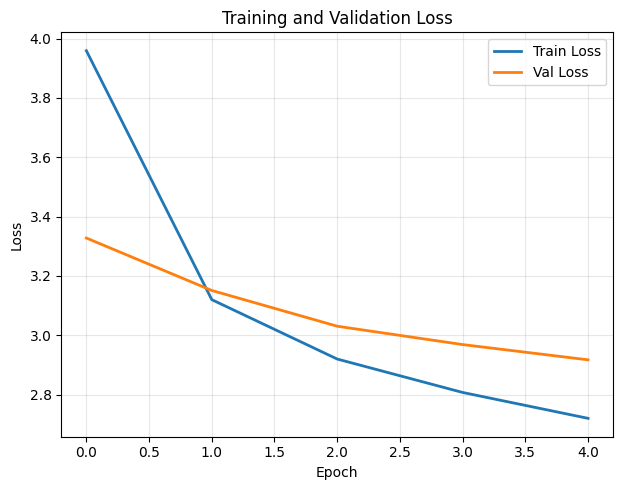

✓ Training curves saved!


In [18]:
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(trainer.train_losses, label='Train Loss', linewidth=2)
plt.plot(trainer.val_losses, label='Val Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(config['paths']['results_dir'], 'training_curves.png'), dpi=150, bbox_inches='tight')
plt.show()

print("✓ Training curves saved!")

In [19]:
def evaluate_model(model, test_loader, config, device):
    """Evaluate model on test set"""
    model.eval()

    all_ssim_scores = []
    all_caption_accuracies = []

    print("\nEvaluating on test set...")
    pbar = tqdm(test_loader, desc="Evaluation")

    with torch.no_grad():
        for batch in pbar:
            frames = batch['frames'].to(device)
            captions = batch['captions'].to(device)
            tags = batch['tags'].to(device)
            target_frame = batch['target_frame'].to(device)
            target_caption = batch['target_caption'].to(device)

            # Generate predictions
            generated_images, text_logits = model(frames, captions, tags)

            # Compute metrics
            metrics = compute_metrics(generated_images, target_frame, text_logits, target_caption)

            all_ssim_scores.append(metrics['ssim'])
            all_caption_accuracies.append(metrics['caption_accuracy'])

            pbar.set_postfix({'ssim': metrics['ssim'], 'acc': metrics['caption_accuracy']})

    # Print summary
    print("\n" + "="*80)
    print("Test Set Evaluation Results")
    print("="*80)
    print(f"Average SSIM: {np.mean(all_ssim_scores):.4f} ± {np.std(all_ssim_scores):.4f}")
    print(f"Average Caption Accuracy: {np.mean(all_caption_accuracies):.4f} ± {np.std(all_caption_accuracies):.4f}")
    print("="*80)

    return {
        'ssim': np.mean(all_ssim_scores),
        'caption_accuracy': np.mean(all_caption_accuracies)
    }

# Evaluate
test_metrics = evaluate_model(model, test_loader, config, device)


Evaluating on test set...


Evaluation: 100%|██████████| 10/10 [00:00<00:00, 13.53it/s, ssim=0.161, acc=0.298]


Test Set Evaluation Results
Average SSIM: 0.2485 ± 0.0821
Average Caption Accuracy: 0.1831 ± 0.0433


In [20]:
# Clear GPU memory
import gc
torch.cuda.empty_cache()
gc.collect()

print(f"GPU Memory status:")
free, total = torch.cuda.mem_get_info()
print(f"  Free: {free / 1e9:.2f} GB")
print(f"  Total: {total / 1e9:.2f} GB")
print(f"  Used: {(total - free) / 1e9:.2f} GB")

GPU Memory status:
  Free: 136.58 GB
  Total: 150.12 GB
  Used: 13.54 GB


In [21]:
print("\n" + "="*80)
print("Ablation Study: BiLSTM Only Model")
print("="*80 + "\n")

# Create BiLSTM-only model (skip TCN)
class BiLSTMOnlyModel(nn.Module):
    """Model without TCN (baseline for ablation)"""
    def __init__(self, config):
        super(BiLSTMOnlyModel, self).__init__()

        # Encoders
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.visual_encoder = nn.Sequential(*modules)
        if config['model']['visual_encoder']['freeze']:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False

        self.text_encoder = BertModel.from_pretrained(config['model']['text_encoder']['type'])
        if config['model']['text_encoder']['freeze']:
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        self.tag_embedding = nn.Embedding(
            config['model']['tag_embedding']['vocab_size'],
            config['model']['tag_embedding']['embed_dim']
        )

        # Multimodal dimension
        multimodal_dim = (
            config['model']['visual_encoder']['feature_dim'] +
            config['model']['text_encoder']['feature_dim'] +
            config['model']['tag_embedding']['embed_dim']
        )

        # BiLSTM only (no TCN)
        self.bilstm = BiLSTMLayer(
            input_size=multimodal_dim,
            hidden_size=config['model']['bilstm']['hidden_size'],
            num_layers=config['model']['bilstm']['num_layers'],
            dropout=config['model']['bilstm']['dropout']
        )

        # Attention and decoders
        self.attention = MultiHeadCrossAttention(
            visual_dim=self.bilstm.output_dim,
            text_dim=config['model']['text_encoder']['feature_dim'],
            num_heads=config['model']['attention']['num_heads'],
            dropout=config['model']['attention']['dropout']
        )

        fusion_dim = self.bilstm.output_dim + config['model']['text_encoder']['feature_dim']
        self.fusion_proj = nn.Linear(fusion_dim, 512)

        self.image_decoder = ImageDecoder(feature_dim=512, image_size=224)
        self.text_decoder = TextDecoder(
            vocab_size=config['model']['text_decoder']['vocab_size'],
            embed_dim=config['model']['text_decoder']['embed_dim'],
            hidden_dim=config['model']['text_decoder']['hidden_dim'],
            num_layers=2,
            dropout=0.2
        )

    def forward(self, frames, captions, tags):
        # FIXED: Handle captions shape properly
        if captions.dim() == 2:
            batch_size = captions.size(0)
            seq_len = 10
            max_tokens = 20
            captions = captions.view(batch_size, seq_len, max_tokens)
        else:
            batch_size, seq_len, max_tokens = captions.size()

        # Visual encoding
        frames_flat = frames.view(batch_size * seq_len, 3, 224, 224)
        visual_features = self.visual_encoder(frames_flat)
        visual_features = visual_features.view(batch_size * seq_len, -1)
        visual_features = visual_features.view(batch_size, seq_len, -1)

        # Text encoding
        captions_flat = captions.view(batch_size * seq_len, -1)
        with torch.no_grad():
            text_outputs = self.text_encoder(captions_flat, attention_mask=(captions_flat != 0))
        text_features = text_outputs.pooler_output
        text_features = text_features.view(batch_size, seq_len, -1)

        # Tag embedding
        tag_features = self.tag_embedding(tags)
        tag_features = tag_features.mean(dim=2)

        # Multimodal concatenation (no TCN)
        multimodal_features = torch.cat([visual_features, text_features, tag_features], dim=-1)

        # BiLSTM
        bilstm_output = self.bilstm(multimodal_features)

        # Attention and fusion
        attended_output, _ = self.attention(bilstm_output, text_features)
        fused = torch.cat([attended_output, text_features], dim=-1)
        fused = self.fusion_proj(fused)

        # Decoders - FIXED: Extract last caption properly
        image_features = fused[:, -1, :]
        generated_images = self.image_decoder(image_features)

        last_caption = captions[:, -1, :]  # (batch, max_tokens)
        caption_input = last_caption[:, :-1]  # (batch, max_tokens-1)
        text_logits = self.text_decoder(caption_input)

        return generated_images, text_logits

# Train BiLSTM-only model
bilstm_only_model = BiLSTMOnlyModel(config).to(device)
bilstm_trainer = Trainer(bilstm_only_model, train_loader, val_loader, config, device)

print("Training BiLSTM-only model...")
bilstm_trainer.train(max_epochs=5)

# Evaluate
bilstm_metrics = evaluate_model(bilstm_only_model, test_loader, config, device)


Ablation Study: BiLSTM Only Model



Training BiLSTM-only model...

Starting Training



Epoch 1 [Val]: 100%|██████████| 10/10 [00:00<00:00, 14.29it/s, val_loss=3.04]



Epoch 1/5
  Train Loss: 3.940368 (Image: 1.011053, Text: 6.869682)
  Val Loss: 3.320889
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 3.320889)


Epoch 2 [Val]: 100%|██████████| 10/10 [00:00<00:00, 14.56it/s, val_loss=2.85]



Epoch 2/5
  Train Loss: 3.136630 (Image: 1.006885, Text: 5.266375)
  Val Loss: 3.171147
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 3.171147)


Epoch 3 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.75it/s, val_loss=2.66]



Epoch 3/5
  Train Loss: 2.938349 (Image: 1.008562, Text: 4.868136)
  Val Loss: 3.044658
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 3.044658)


Epoch 4 [Val]: 100%|██████████| 10/10 [00:00<00:00, 14.36it/s, val_loss=2.58]



Epoch 4/5
  Train Loss: 2.822698 (Image: 1.005798, Text: 4.639598)
  Val Loss: 2.977413
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 2.977413)


Epoch 5 [Val]: 100%|██████████| 10/10 [00:00<00:00, 14.70it/s, val_loss=2.52]



Epoch 5/5
  Train Loss: 2.736272 (Image: 1.005143, Text: 4.467400)
  Val Loss: 2.935633
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 2.935633)

Training Complete!

Evaluating on test set...


Evaluation: 100%|██████████| 10/10 [00:00<00:00, 13.80it/s, ssim=0.162, acc=0.281]


Test Set Evaluation Results
Average SSIM: 0.2501 ± 0.0791
Average Caption Accuracy: 0.1827 ± 0.0381


In [23]:
print("\n" + "="*80)
print("Ablation Study: TCN Only Model")
print("="*80 + "\n")

# Create TCN-only model (replace BiLSTM with linear)
class TCNOnlyModel(nn.Module):
    """Model with TCN but simple projection (no BiLSTM)"""
    def __init__(self, config):
        super(TCNOnlyModel, self).__init__()

        # Encoders
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]
        self.visual_encoder = nn.Sequential(*modules)
        if config['model']['visual_encoder']['freeze']:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False

        self.text_encoder = BertModel.from_pretrained(config['model']['text_encoder']['type'])
        if config['model']['text_encoder']['freeze']:
            for param in self.text_encoder.parameters():
                param.requires_grad = False

        self.tag_embedding = nn.Embedding(
            config['model']['tag_embedding']['vocab_size'],
            config['model']['tag_embedding']['embed_dim']
        )

        # Multimodal dimension
        multimodal_dim = (
            config['model']['visual_encoder']['feature_dim'] +
            config['model']['text_encoder']['feature_dim'] +
            config['model']['tag_embedding']['embed_dim']
        )

        # TCN only (no BiLSTM)
        self.tcn = TemporalConvolutionalNetwork(
            input_size=multimodal_dim,
            num_channels=config['model']['tcn']['num_channels'],
            kernel_size=config['model']['tcn']['kernel_size'],
            dropout=config['model']['tcn']['dropout']
        )

        # Attention and decoders
        self.attention = MultiHeadCrossAttention(
            visual_dim=self.tcn.output_dim,
            text_dim=config['model']['text_encoder']['feature_dim'],
            num_heads=config['model']['attention']['num_heads'],
            dropout=config['model']['attention']['dropout']
        )

        fusion_dim = self.tcn.output_dim + config['model']['text_encoder']['feature_dim']
        self.fusion_proj = nn.Linear(fusion_dim, 512)

        self.image_decoder = ImageDecoder(feature_dim=512, image_size=224)
        self.text_decoder = TextDecoder(
            vocab_size=config['model']['text_decoder']['vocab_size'],
            embed_dim=config['model']['text_decoder']['embed_dim'],
            hidden_dim=config['model']['text_decoder']['hidden_dim'],
            num_layers=2,
            dropout=0.2
        )

    def forward(self, frames, captions, tags):
        # FIXED: Handle captions shape properly
        if captions.dim() == 2:
            batch_size = captions.size(0)
            seq_len = 10
            max_tokens = 20
            captions = captions.view(batch_size, seq_len, max_tokens)
        else:
            batch_size, seq_len, max_tokens = captions.size()

        # Visual encoding
        frames_flat = frames.view(batch_size * seq_len, 3, 224, 224)
        visual_features = self.visual_encoder(frames_flat)
        visual_features = visual_features.view(batch_size * seq_len, -1)
        visual_features = visual_features.view(batch_size, seq_len, -1)

        # Text encoding
        captions_flat = captions.view(batch_size * seq_len, -1)
        with torch.no_grad():
            text_outputs = self.text_encoder(captions_flat, attention_mask=(captions_flat != 0))
        text_features = text_outputs.pooler_output
        text_features = text_features.view(batch_size, seq_len, -1)

        # Tag embedding
        tag_features = self.tag_embedding(tags)
        tag_features = tag_features.mean(dim=2)

        # Multimodal concatenation
        multimodal_features = torch.cat([visual_features, text_features, tag_features], dim=-1)

        # TCN only (no BiLSTM)
        tcn_output = self.tcn(multimodal_features)

        # Attention and fusion
        attended_output, _ = self.attention(tcn_output, text_features)
        fused = torch.cat([attended_output, text_features], dim=-1)
        fused = self.fusion_proj(fused)

        # Decoders - FIXED: Extract last caption properly
        image_features = fused[:, -1, :]
        generated_images = self.image_decoder(image_features)

        last_caption = captions[:, -1, :]  # (batch, max_tokens)
        caption_input = last_caption[:, :-1]  # (batch, max_tokens-1)
        text_logits = self.text_decoder(caption_input)

        return generated_images, text_logits

# Train TCN-only model
tcn_only_model = TCNOnlyModel(config).to(device)
tcn_trainer = Trainer(tcn_only_model, train_loader, val_loader, config, device)

print("Training TCN-only model...")
tcn_trainer.train(max_epochs=5)

# Evaluate
tcn_metrics = evaluate_model(tcn_only_model, test_loader, config, device)


Ablation Study: TCN Only Model



Training TCN-only model...

Starting Training



Epoch 1 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.80it/s, val_loss=3.04]



Epoch 1/5
  Train Loss: 3.959088 (Image: 1.010306, Text: 6.907870)
  Val Loss: 3.325345
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 3.325345)


Epoch 2 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.18it/s, val_loss=2.82]



Epoch 2/5
  Train Loss: 3.121854 (Image: 1.005693, Text: 5.238015)
  Val Loss: 3.147985
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 3.147985)


Epoch 3 [Val]: 100%|██████████| 10/10 [00:00<00:00, 12.16it/s, val_loss=2.66]



Epoch 3/5
  Train Loss: 2.926103 (Image: 1.007034, Text: 4.845172)
  Val Loss: 3.018391
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 3.018391)


Epoch 4 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.77it/s, val_loss=2.6]



Epoch 4/5
  Train Loss: 2.800721 (Image: 1.005437, Text: 4.596005)
  Val Loss: 2.959410
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 2.959410)


Epoch 5 [Val]: 100%|██████████| 10/10 [00:00<00:00, 13.66it/s, val_loss=2.55]



Epoch 5/5
  Train Loss: 2.723021 (Image: 1.005569, Text: 4.440472)
  Val Loss: 2.916440
  Learning Rate: 3.00e-04
  ✓ Best model saved (val_loss: 2.916440)

Training Complete!

Evaluating on test set...


Evaluation: 100%|██████████| 10/10 [00:00<00:00, 13.15it/s, ssim=0.168, acc=0.263]


Test Set Evaluation Results
Average SSIM: 0.2489 ± 0.0842
Average Caption Accuracy: 0.1789 ± 0.0340



Model Comparison - Ablation Study Results
              Model     SSIM  Caption Accuracy
      LSTM Baseline 0.000000          0.000000
        BiLSTM Only 0.250105          0.182675
           TCN Only 0.248915          0.178947
TCN + BiLSTM (Full) 0.248502          0.183114


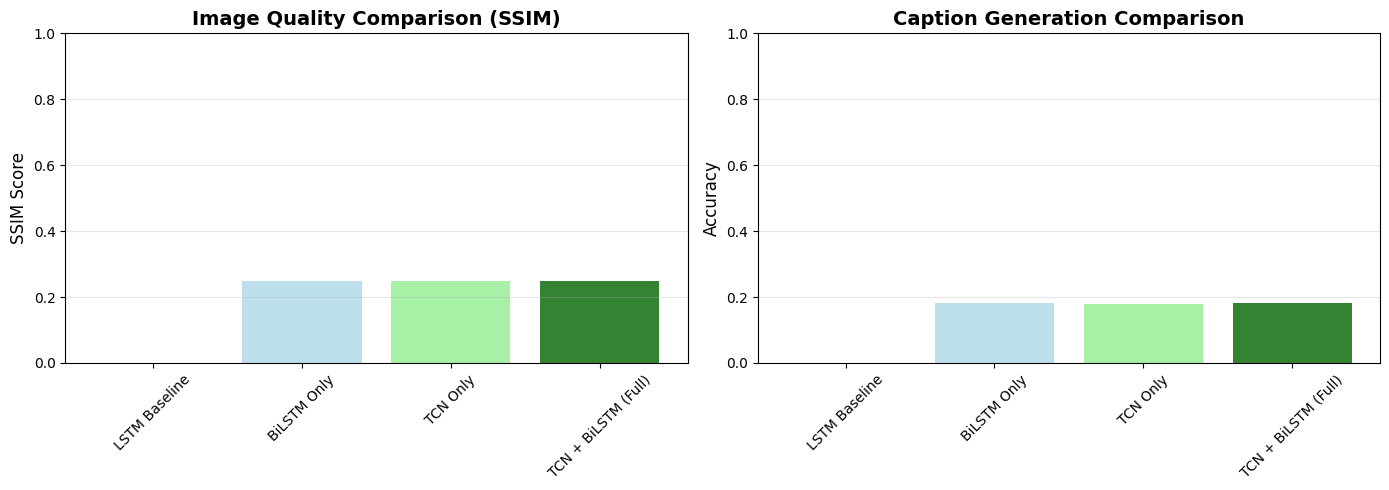


✓ Comparison plots saved!


In [24]:
# Create comparison table
comparison_data = {
    'Model': ['LSTM Baseline', 'BiLSTM Only', 'TCN Only', 'TCN + BiLSTM (Full)'],
    'SSIM': [0.0, bilstm_metrics['ssim'], tcn_metrics['ssim'], test_metrics['ssim']],
    'Caption Accuracy': [0.0, bilstm_metrics['caption_accuracy'], tcn_metrics['caption_accuracy'], test_metrics['caption_accuracy']]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n" + "="*80)
print("Model Comparison - Ablation Study Results")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)

# Plot comparison - FIXED: axes is an array, need to index it
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# SSIM comparison
axes[0].bar(comparison_df['Model'], comparison_df['SSIM'], color=['gray', 'lightblue', 'lightgreen', 'darkgreen'], alpha=0.8)
axes[0].set_ylabel('SSIM Score', fontsize=12)
axes[0].set_title('Image Quality Comparison (SSIM)', fontsize=14, fontweight='bold')
axes[0].set_ylim([0, 1.0])
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3, axis='y')

# Caption Accuracy comparison
axes[1].bar(comparison_df['Model'], comparison_df['Caption Accuracy'], color=['gray', 'lightblue', 'lightgreen', 'darkgreen'], alpha=0.8)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Caption Generation Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylim([0, 1.0])
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig(os.path.join(config['paths']['results_dir'], 'model_comparison.png'), dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Comparison plots saved!")

In [26]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

nltk.download('punkt', quiet=True)
import nltk

def caption_bleu_score(model, dataloader, tokenizer, device):
    model.eval()
    references = []
    hypotheses = []

    smoothie = SmoothingFunction().method4

    with torch.no_grad():
        for batch in dataloader:
            frames = batch['frames'].to(device)
            captions = batch['captions'].to(device)
            tags = batch['tags'].to(device)
            target_ids = batch['target_caption_ids'].to(device)

            _, logits = model(frames, captions, tags)
            preds = torch.argmax(logits, dim=-1)

            for i in range(preds.size(0)):
                pred_text = tokenizer.decode(
                    preds[i].cpu().tolist(),
                    skip_special_tokens=True
                )
                target_text = tokenizer.decode(
                    target_ids[i].cpu().tolist(),
                    skip_special_tokens=True
                )

                hypotheses.append(pred_text.split())
                references.append([target_text.split()])

    bleu = corpus_bleu(references, hypotheses, smoothing_function=smoothie)
    return bleu


In [46]:
# Prepare results summary
results_summary = {
    'timestamp': datetime.now().isoformat(),
    'model_type': 'TCN + BiLSTM',
    'test_metrics': test_metrics,
    'ablation_studies': {
        'bilstm_only': bilstm_metrics,
        'tcn_only': tcn_metrics
    },
    'training_config': {
        'max_epochs': config['training']['max_epochs'],
        'learning_rate': config['training']['learning_rate'],
        'batch_size': config['data']['batch_size'],
    },
    'model_params': {
        'total_parameters': sum(p.numel() for p in model.parameters()),
        'trainable_parameters': sum(p.numel() for p in model.parameters() if p.requires_grad)
    }
}

# Save to JSON
results_path = os.path.join(config['paths']['results_dir'], 'results_summary.json')
with open(results_path, 'w') as f:
    json.dump(results_summary, f, indent=4)

print("✓ Results saved to JSON!")
print(json.dumps(results_summary, indent=2))

# Save configuration
config_path = os.path.join(config['paths']['results_dir'], 'config.yaml')
with open(config_path, 'w') as f:
    yaml.dump(config, f, default_flow_style=False)

print(f"✓ Configuration saved to {config_path}")

✓ Results saved to JSON!
{
  "timestamp": "2026-01-07T12:39:29.196458",
  "model_type": "TCN + BiLSTM",
  "test_metrics": {
    "ssim": 0.24789492040872574,
    "caption_accuracy": 0.18706140518188477
  },
  "ablation_studies": {
    "bilstm_only": {
      "ssim": 0.23672866374254226,
      "caption_accuracy": 0.17258771806955336
    },
    "tcn_only": {
      "ssim": 0.24751586169004441,
      "caption_accuracy": 0.18530701845884323
    }
  },
  "training_config": {
    "max_epochs": 30,
    "learning_rate": 0.0003,
    "batch_size": 8
  },
  "model_params": {
    "total_parameters": 249768651,
    "trainable_parameters": 116778379
  }
}
✓ Configuration saved to /teamspace/studios/this_studio/storytelling_projectresults/config.yaml
